(qml001)=
# QML 001 - A summary of classical supervised learning

In this tutorial, we will discuss some basic ideas behind classical supervised learning before we jump into the quantum part. 

The notebook is structured as follows:

- We introduce the learning task of classifying data points $x_i$ with labels $y_i$
- We introduce simple classification through logistic regression with bias and weight.
- We provide simple training
- We test the performance of the circuit.


We will always focus on simplicity throughout this tutorial and leave the more complex discussions to the extensive literature. So readers thank think "yet another tutorial on logistic regression", can most likely directly jump to the very [first tutorial](qml101) on quantum machine learning.

## A simple learning task

For simplicity we will start out with a simple problem, where each data set has only a single variable and extend it later to higher dimensional data sets.

In [ ]:
from typing import Union, List

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm


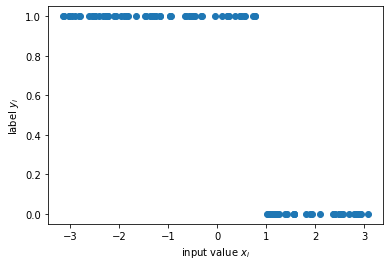

In [ ]:
np.random.seed(1)
x = np.random.uniform(-np.pi, np.pi, 100)
y = 1.0* (x <  1)

f, ax = plt.subplots()
ax.plot(x, y, "o")
ax.set_xlabel(r"input value $x_i$");
ax.set_ylabel(r"label $y_i$");

The learning task is now  to predict the label $y_i$ from the input value $x_i$. To get started we have to divide the data set into a training part and a test part:

- On the *training set* we will optimize the algorithm to achieve the highest possible accuracy in predicting the label.
- On the *test set* we will test the performance of the algorithm with data it has never seen.

The usual problem is here to find a good balance between a sufficient amount of training data, yet leaving enough test data to have a statistically significant test.

In [ ]:
from sklearn.model_selection import train_test_split

Text(0.5, 1.0, 'test data')

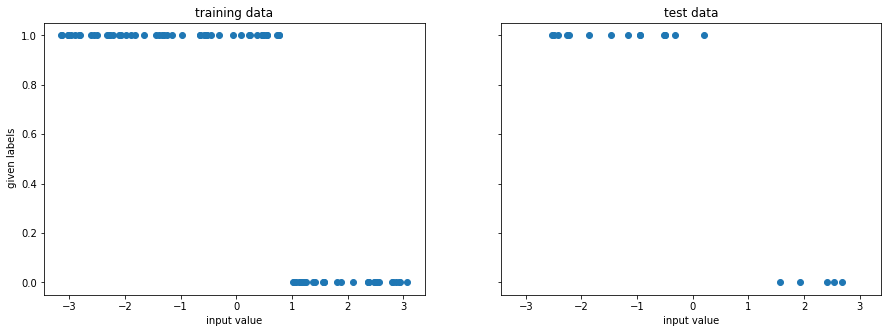

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42
)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax1.plot(x_train, y_train, "o")
ax1.set_xlabel("input value")
ax1.set_ylabel(" given labels")
ax1.set_title("training data")

ax2.plot(x_test, y_test, "o")
ax2.set_xlabel("input value")
ax2.set_title("test data")

## Logistice regression as a minimal algorithm

It is now time to set up the algorithm for the training. We will use [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), despite the fact that this horse has been ridden to death. It is has just all the right ingredients that are necessary to agree on basic concepts and notations. The logistic function itself is defined as:

$$
p(x) = \frac{1}{1+e^{-(W\cdot x+b)}}
$$

It has a number of useful properties for us:

- It interpolates nicely between 0 and 1.
- The value of the transition is set by the *bias* $b$. For $x \gg b$ the exponential goes to zero and $p(x) \rightarrow 1$, while it goes to 0 for the other side. 
- The sharpness of the transition is set by the weight $W$, which tells us how much of an influence we should attach to the input value $x$.

Below you can find a general example of such a logistic regression.

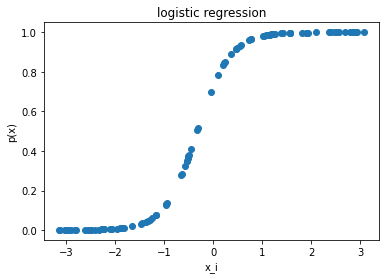

In [ ]:
weight = 3
bias = 1

y_log = 1/(1+np.exp(-(weight*x+bias)))
f, ax = plt.subplots()
ax.plot(x, y_log, 'o')
ax.set_xlabel('x_i')
ax.set_ylabel('p(x)')
ax.set_title("logistic regression");

We can use this logistic regression for labelling, but simply deciding that the label is 0, if $p(x) <\frac{1}{2}$ and and 1 if $p(x) > \frac{1}{2}$.

In [ ]:
def get_accuracy(weight: float, bias: float, xvals: List[float], yvals: List[int]
) -> Union[float, List[int]]:
    """
    Calculates the accuracy of the logistic regression for a given set of data.

    Args:
      weight: the training parameter for the weight
      bias: the training parameter for the bias
      xvals: the input values
      yvals: the labels
    Returns:
      The accuracy and the predicted labels.
    """
    pred_labels = np.zeros(len(xvals))
    accurate_prediction = 0
    for ii, xinput, yinput in zip(range(len(xvals)), xvals, yvals.astype(int)):
        # set the circuit parameter
        y_log = 1/(1+np.exp(-(weight*xinput+bias)))
        pred_label = 1.0*(y_log>1/2)
        pred_labels[ii] = pred_label
        if yinput == pred_label:
            accurate_prediction += 1
    return accurate_prediction / len(yvals), pred_labels

And now we can have a look at the labeling with some randomly guessed initial values.

The circuit has an accuracy of 0.85


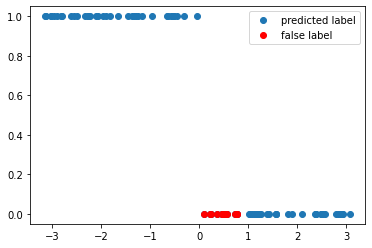

In [ ]:
weight = -0.8
bias = 0
accuracy, y_pred = get_accuracy(bias = bias, weight=weight, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

print(f"The circuit has an accuracy of {accuracy}")
f, ax = plt.subplots()
ax.plot(x_train, y_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()

As we can see above there is quite a regime, where the model does to predict the labels very well. This can be improved by training the model parameters systematically. 

## Training the minimalistic algorithm

To improve the performance of the circuit, we have to train it. This basically involves the minimization of some loss function as a function of the circuit parameters $W$ and $b$. In this example, we can simply calculate the accuracy of the circuit as a function of the bias and obtain its minimimum.

In [ ]:
weight = -1

Nbias = 101
biases = np.linspace(-2, 2, Nbias)
accuracies = np.zeros(Nbias)

for ii, bias_val in enumerate(tqdm(biases)):
    accuracy, y_pred = get_accuracy(bias = bias_val, weight=weight, xvals=x_train, yvals=y_train)
    accuracies[ii] = accuracy

100%|██████████| 101/101 [00:00<00:00, 761.27it/s]


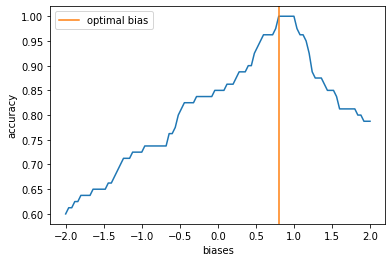

In [ ]:
opt_bias = biases[accuracies.argmax()]

f, ax = plt.subplots()
ax.plot(biases, accuracies)
ax.axvline(opt_bias, color="C1", label="optimal bias")
ax.set_ylabel("accuracy")
ax.set_xlabel("biases")
ax.legend()

We clearly identify a optimal value for the bias at which the accuracy is maximal. This allows to test the accuracy on the optimal value of the weights again to obtain.

The trained circuit has an accuracy of 1.0


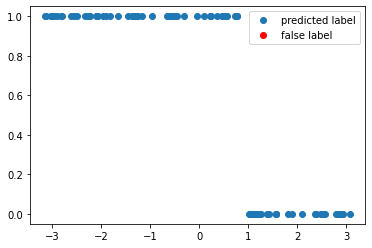

In [ ]:
accuracy, y_pred = get_accuracy(bias = opt_bias , weight= weight, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

f, ax = plt.subplots()
ax.plot(x_train, y_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()


print(f"The trained circuit has an accuracy of {accuracy:.2}")

## Testing the algorithm

Having finished the training, we can test the circuit now on data points that it has never seen.

The circuit has a test accuracy of 1.0


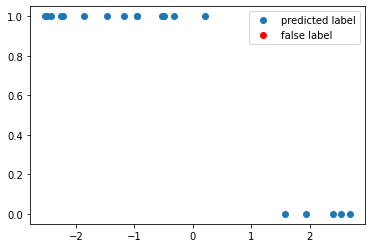

In [ ]:
test_accuracy, y_test_pred = get_accuracy(
    bias = opt_bias, weight=weight, xvals=x_test, yvals=y_test
)

false_label = abs(y_test_pred - y_test) > 0

x_false = x_test[false_label]
y_false = y_test_pred[false_label]

print(f"The circuit has a test accuracy of {test_accuracy:.2}")
f, ax = plt.subplots()
ax.plot(x_test, y_test_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend();

## Summary of classical supervised learning

In this tutorial, we studied some basic concepts like training and classification for an extremely simple case. We saw:

- the existence of a classification algorithm.
- How it relates input and output label.
- How it is trained.
- How it is tested on test data.

In the [first tutorial on QML](https://colab.research.google.com/drive/1XMkIBrU1lBLTT-oVufVTifHivss0HDI1?usp=sharing), we will see how this translate in the simplest fashion to quantum algorithms.
